In [50]:
import pandas as pd
import pickle
from sklearn import linear_model
import numpy as np
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier


#Output of the Prediction for matchday (9 games)
# Form: Home_team, Away_team, Prediction
# Prediction over 0.5 is a Victory for Home Team
# Prediction under 0.5 is a Loss for Home Team
# Else Draw
"""
This function generates the output for the prediciton of the match day. 
It will show 9 matches. Each match has the form: [team1, team2, prediction]
"""
def output(team1,team2,prediction):
    match_day=[]
    for i in range(0,9):
        game= [team1[i],team2[i],prediction[i]]
        match_day.append(game)
    return match_day

#Modification: Home Team gets an 1, Away Team a -1
#Idea: Home Team has an advantage with fans
"""
This function is a special for the function table. The function will called, 
if the first match should be predicted. 
The function creates a df, which shows which teams play against each other. 
The form is team_home= 1 and team_away= -1 
"""
def table_one_matchday(dfmod):
    df_visitor = pd.get_dummies(dfmod['team2'], dtype=np.int64)
    df_visitor= df_visitor*-1
    df_home = pd.get_dummies(dfmod['team1'], dtype=np.int64)
    df_model=pd.concat([df_home,df_visitor],axis=1)
    return df_model

#Modification: Home Teams gets a 1, Away Team -1
#Iterate through each line
#Fix Nan Values
def table(dfmod,anfrage,begin,end):
    #Only one Match => call table_one_match
    #to avoid NAN mistakes (only 9 teams in team1 und team2)
    if (begin-end)==9:
        df_model= table_one_matchday(dfmod)
        for i in anfrage:
            df_model[i] = dfmod[i]
        return df_model

    df_visitor = pd.get_dummies(dfmod['team2'], dtype=np.int64)
    df_home = pd.get_dummies(dfmod['team1'], dtype=np.int64)

    #Error correction in table (NaN)
    nan_home=[]
    for (columnName, columnData) in df_home.iteritems():
        team= columnName
        if np.nansum(columnData.values)>1:
            teamvalues= [team,columnData.values]
            nan_home.append(teamvalues)

    nan_away=[]
    for (columnName, columnData) in df_visitor.iteritems():
        team= columnName
        if np.nansum(columnData.values)>1:
            columnData = columnData*-1
            teamvalues= [team,columnData.values]
            nan_away.append(teamvalues)
            
    #Transformation: 1:Home team, -1: Away team
    df_model = df_home.sub(df_visitor)
    for i in anfrage:
        df_model[i] = dfmod[i]
        
    #If one team has only home matches, you have to modify the values, otherwise nan values
    count=0
    for (columnName, columnData) in df_model.iteritems():

        if np.isnan(np.sum(columnData.values)):
            for i in nan_home:
                if columnName==i[0]:
                    df_model[columnName]= i[1]
            for i in nan_away:
                if columnName==i[0]:
                    df_model[columnName]=i[1]
    return df_model

#Collect the data of the pkl. to df
#Each Feature is a List
#Take only the Data of the Features (arg: anfrage) for an area of matchdays (arg: begin, end)
def read_data(gamedata,begin,end,anfrage):    
    team1=[]
    team2=[]
    goals= []
    shots=[]
    request_efficiency=[]
    request_foul=[]
    request_possession=[]
    request_pass=[]
    request_run=[]
    request_duels=[]
    request_shots=[]
    request_passes=[]
    request_succsessPasses=[]
    request_unsuccessPasses=[]
    request_afoul=[]
    request_offside=[]
    request_corners=[]
    results=[]

    count=0
    dfmod= ""
    with (open(gamedata, "rb")) as openfile:
        while True:
            try:
                if count< end:
                    spieltag= pickle.load(openfile)
                    #print(spieltag)
                    #print(spieltag[1], spieltag[2], spieltag[4][0:2], spieltag[5][0:2])
                    if spieltag[1]=="team1":
                        continue
                    if count >= begin:
                        team1.append(spieltag[1])
                        team2.append(spieltag[2])
                        for i in anfrage:
                            #print(i)
                            if i=="efficieny":
                                eff_heim= int(spieltag[4][0])/int(spieltag[4][1])
                                eff_gast= int(spieltag[5][0])/int(spieltag[5][1])
                                effi_gesamt= eff_heim-eff_gast
                                #print(effi_gesamt)
                                request_efficiency.append(effi_gesamt)
                            elif i=="possession":
                                ballbesitz_heim= int(spieltag[4][7][:-1])
                                ballbesitz_gast= int(spieltag[5][7][:-1])
                                ballbesitz_gesamt= ballbesitz_heim/ballbesitz_gast
                                request_possession.append(ballbesitz_gesamt)
                            elif i=="shots":
                                shots_home= int(spieltag[4][1])
                                shots_away= int(spieltag[5][1])
                                shots_total= shots_home/shots_away
                                request_shots.append(shots_total)
                            elif i=="pass":
                                paesse_heim= int(spieltag[4][3])
                                paesse_gast= int(spieltag[5][3])
                                paesse_gesamt= paesse_heim/paesse_gast
                                request_pass.append(paesse_gesamt)
                            elif i=="spasses":
                                epaesse_heim= int(spieltag[4][4])
                                epaesse_gast= int(spieltag[5][4])
                                epaesse_gesamt= epaesse_heim/epaesse_gast
                                request_succsessPasses.append(epaesse_gesamt)
                            elif i=="upasses":
                                fpaesse_heim= int(spieltag[4][5])
                                fpaesse_gast= int(spieltag[5][5])
                                fpaesse_gesamt= fpaesse_heim/fpaesse_gast
                                request_unsuccessPasses.append(fpaesse_gesamt)
                            elif i=="foul":
                                foul_heim= int(spieltag[4][9])
                                foul_gast= int(spieltag[5][9])
                                foul_gesamt= foul_heim/foul_gast
                                request_foul.append(foul_gesamt)
                            elif i=="afoul":
                                gfoul_heim= int(spieltag[4][10])
                                gfoul_gast= int(spieltag[5][10])
                                gfoul_gesamt= gfoul_heim/gfoul_gast
                                request_afoul.append(gfoul_gesamt)
                            elif i=="offside":
                                a_heim= int(spieltag[4][11])
                                a_gast= int(spieltag[5][11])
                                if a_gast==0:
                                    a_gast=1
                                if a_heim==0:
                                    a_heim=1
                                
                                a_gesamt= a_heim/a_gast
                                request_offside.append(a_gesamt)
                            elif i=="corners":
                                ecken_heim= int(spieltag[4][12])
                                ecken_gast= int(spieltag[5][12])
                                if ecken_heim==0:
                                    ecken_heim=1
                                if ecken_gast==0:
                                    ecken_gast=1
                                ecken_gesamt= ecken_heim/ecken_gast
                                request_corners.append(ecken_gesamt)
                            elif i=="run":
                                km_heim= float((spieltag[4][2][:-2]).replace(",","."))
                                km_gast= float((spieltag[5][2][:-2]).replace(",","."))
                                lauf_gesamt= km_heim/km_gast
                                request_run.append(lauf_gesamt)
                            elif i=="passes":
                                passen_heim= int(spieltag[4][6][:-1])
                                passen_gast= int(spieltag[5][6][:-1])
                                passen_gesamt= passen_heim/passen_gast
                                request_passes.append(passen_gesamt)
                                #print(passen_gesamt)
                            elif i=="duels":
                                zweikampf_heim= int(spieltag[4][8][:-1])
                                zweikampf_gast= int(spieltag[5][8][:-1])
                                zweikampf_gesamt= zweikampf_heim/zweikampf_gast
                                request_duels.append(zweikampf_gesamt)
                            
            
                        ergebnis= (spieltag[4][0:1][0])+":"+(spieltag[5][0:1][0])
                        results.append(ergebnis)
                        data= {"team1":team1,"team2":team2}
                        for i in anfrage:
                            if i=="efficiency":
                                data.update({i:request_efficiency})
                            if i=="foul":
                                data.update({i:request_foul})
                            if i=="run":
                                data.update({i:request_run})
                            if i=="pass":
                                data.update({i:request_pass})
                            if i=="duels":
                                data.update({i:request_duels})
                            if i=="shots":
                                data.update({i:request_shots})
                            if i=="passes":
                                data.update({i:request_passes})
                            if i=="spasses":
                                data.update({i:request_succsessPasses})
                            if i=="upasses":
                                data.update({i:request_unsuccessPasses})
                            if i=="possession":
                                data.update({i:request_possession})
                            if i=="afoul":
                                data.update({i:request_afoul})
                            if i=="offside":
                                data.update({i:request_offside})
                            if i=="corners":
                                data.update({i:request_corners})
                            
                        #print(data)

                        dfmod= pd.DataFrame(data)
                        
                    count=count+1
                else:
                    break
            except EOFError:
                break
    return dfmod, team1,team2,results


def ytransform(y,art):
    if art=="TSNE":
        return TSNE(n_components=1).fit_transform(y)
    elif art=="PCA":
        return PCA(n_components=1).fit_transform(y)
    return "Fehler"

#Collect all Data whitch are quiered.
#Predict with Linear Regression
def Statistik(gamedata, begin,end,anfrage):
    
    begin=begin*9+1
    end=end*9+1 
    dfmod,m1,m2,e1= read_data(gamedata,begin,end,anfrage)
    
    #print(dfmod)
    df_visitor = pd.get_dummies(dfmod['team2'], dtype=np.int64)
    df_home = pd.get_dummies(dfmod['team1'], dtype=np.int64)
    df_model= table(dfmod,anfrage,begin,end)
    '''Verwendung von Ridge Regression
        wird verwendet wenn es viele Features besitzt oder wenige Trainingsdaten besitzt
        Vermeidung von Un- oder Ueberanpassung'''

    lr = sklearn.linear_model.Ridge(alpha=0.001)
    rt= RandomForestRegressor()
    X = df_model.drop(anfrage,axis=1)
    #print(X)
    #y-Achse bilden
    if len(anfrage) ==1:
        feature= anfrage[0]
        y= df_model[feature]
        #print(y)
    else:
        y = np.vstack((df_model[anfrage[0]],df_model[anfrage[1]]))
        for i in range(2,len(anfrage)):
            if len(anfrage) <=2:
                break
            else:
                y = np.vstack((y,df_model[anfrage[i]]))
    #print(y)        
    y = y.transpose()
    #print(y)
    # Das gefittete PCA braucht man um andere (Test, oder neue Daten) zu transformen
    # andere wären t-SNE, UMAP
    if len(anfrage)==1:
        y= y.values.reshape(-1,1)
    #print(y)
    y = ytransform(y,"PCA")
    #print(y)
    y = y.reshape(y.shape[0])
    lr.fit(X, y)
    #rt.fit(X,y)

    
    #df_ratings = pd.DataFrame(data={'team': X.columns, 'rating': lr.coef_})
    #coef= df_ratings.values

    #Spiele fuer das naechste Spiel holen und Tabelle erstellen
    dfmod2,m1,m2,results= read_data(gamedata,end,end+9,anfrage)
    df_model2= table_one_matchday(dfmod2)
    df_model2 = pd.DataFrame(data=df_model2)
    prediction= lr.predict(df_model2)
    #prediction=rt.predict(df_model2)
    gesamt = output(m1,m2,prediction)
    return gesamt

#Used Random Forest for Feature Selection
#Which Feature is the best feature to predict football results
def RandomForest(gamedata, begin,end,anfrage):
    
    begin=begin*9
    end=end*9 
    dfmod,m1,m2,e1= read_data(gamedata,begin,end,anfrage)
    X=dfmod.drop(["team1","team2"],axis=1)
    y=[]
    for i in e1:
        numbers= str(i).split(":")
        diff = int(numbers[0])-int(numbers[1])
        if diff>0:
            y.append(1)
        elif diff==0:
            y.append(0)
        elif diff<0:
            y.append(-1)
    y= np.array(y)
    model = RandomForestClassifier(n_estimators=5000, max_features=len(anfrage))
    # fit the model on the whole dataset
    model.fit(X, y)
    #print(model.feature_importances_)
    return model.feature_importances_

#Choice Values for Prediction (Features, area of match days, season of football)
#Print Prediction for football game
def main():
    tanfrage=["shots"]
    #tanfrage=["shots","ecken","ballbesitz","gfoul","paesse","epaesse","abseits","fpaesse","foul","passen","zweikampf","laufen"]

    tbegin=[1]
    tend=[10]

    for i in range(0,len(tbegin)):
        begin_neu=tbegin[i]
        end_neu=tend[i]
        liste= RandomForest("Statistik2019.pkl", begin_neu,end_neu,tanfrage)
        features={}
        for i in range(0,len(liste)):
            features[tanfrage[i]]=liste[i]
        sortierte_features=(sorted(features.items(), key=lambda x: x[1],reverse=True))
        tanfrage_neu=[]
        for i in sortierte_features:
            tanfrage_neu.append(i[0])
            #print(i[0],i[1])
        #tanfrage_neu.pop()
        #tanfrage_neu.pop()
        liste= Statistik("Statistik2019.pkl", begin_neu,end_neu,tanfrage_neu)
        print("Viewing the match days from "+str(begin_neu)+" to "+str(end_neu)+"\n")
        for i in liste:
            print(i)
        print("\n")
main()


Viewing the match days from 1 to 10

['hannover 96', 'vfl wolfsburg', 0.668303020621152]
['1899 hoffenheim', 'fc augsburg', -1.2862462012814917]
['werder bremen', 'borussia mgladbach', 0.3630798154217626]
['sc freiburg', '1 fsv mainz 05', 0.0018088637689501119]
['fortuna duesseldorf', 'hertha bsc', 1.3292106225989326]
['1 fc nuernberg', 'vfb stuttgart', -0.7399391933685137]
['borussia dortmund', 'bayern muenchen', 0.9273674648686056]
['rasenballsport leipzig', 'bayer leverkusen', -0.03557586843632938]
['eintracht frankfurt', 'fc schalke 04', 0.1749216050839979]




In [5]:
#Results 1 Feature
#Tested wirh 1 match, 3 matches, 5 matches, 10 matches days as training
#Tested match days: 11, 21, 31

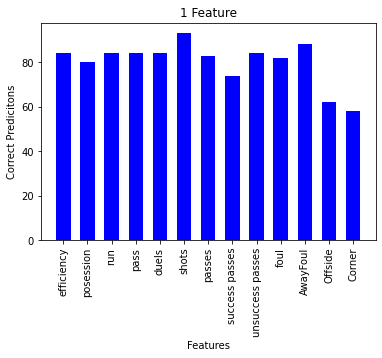

In [6]:
#Plot the results of Excels 

import matplotlib.pyplot as plt

left_coordinates=[1,2,3,4,5,6,7,8,9,10,11,12,13]
heights=[84,80,84,84,84,93,83,74,84,82,88,62,58]
bar_labels=["efficiency", "posession", "run", "pass", "duels", "shots", "passes", "success passes", "unsuccess passes", "foul", "AwayFoul","Offside", "Corner" ]
plt.bar(left_coordinates, heights,tick_label=bar_labels,width=0.6,color=["blue"])
plt.xticks(rotation='vertical')
plt.xlabel('Features')
plt.ylabel("Correct Predicitons")
plt.title("1 Feature")
plt.savefig('1_Feature_correct',bbox_inches='tight') 
plt.show()

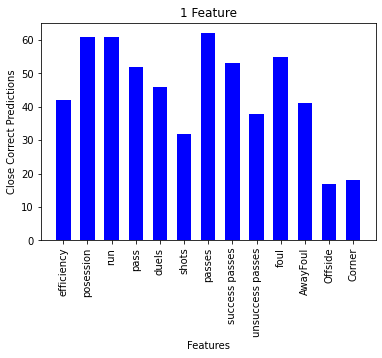

In [7]:
left_coordinates=[1,2,3,4,5,6,7,8,9,10,11,12,13]
heights=[42,61,61,52,46,32,62,53,38,55,41,17,18]
bar_labels=["efficiency", "posession", "run", "pass", "duels", "shots", "passes", "success passes", "unsuccess passes", "foul", "AwayFoul","Offside", "Corner" ]
plt.bar(left_coordinates, heights,tick_label=bar_labels,width=0.6,color=["blue"])
plt.xticks(rotation='vertical')
plt.xlabel('Features')
plt.ylabel("Close Correct Predictions")
plt.title("1 Feature")
plt.savefig('1_Feature_close',bbox_inches='tight') 
plt.show()


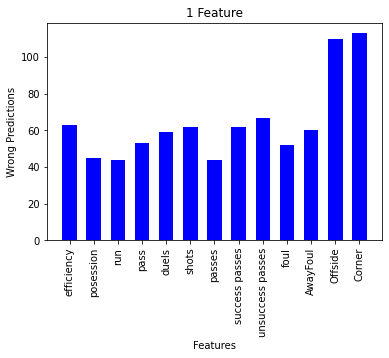

In [8]:
left_coordinates=[1,2,3,4,5,6,7,8,9,10,11,12,13]
heights=[63,45,44,53,59,62,44,62,67,52,60,110,113]
bar_labels=["efficiency", "posession", "run", "pass", "duels", "shots", "passes", "success passes", "unsuccess passes", "foul", "AwayFoul","Offside", "Corner" ]
plt.bar(left_coordinates, heights,tick_label=bar_labels,width=0.6,color=["blue"])
plt.xticks(rotation='vertical')
plt.xlabel('Features')
plt.ylabel("Wrong Predictions")
plt.title("1 Feature")
plt.savefig('1_Feature_wrong',bbox_inches='tight')
plt.show()


In [9]:
#Results Multi Features
#Tested wirh 1 match, 3 matches, 5 matches, 10 matches days as training
#Tested match days: 11, 21, 31

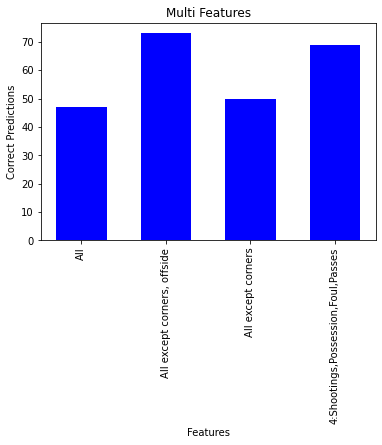

In [10]:
left_coordinates=[1,2,3,4]
heights=[47,73,50,69]
bar_labels=["All", "All except corners, offside", "All except corners", "4:Shootings,Possession,Foul,Passes"]
plt.bar(left_coordinates, heights,tick_label=bar_labels,width=0.6,color=["blue"])
plt.xticks(rotation='vertical')
plt.xlabel('Features')
plt.ylabel("Correct Predictions")
plt.title("Multi Features")
plt.savefig('Multi_Feature_correct',bbox_inches='tight') 
plt.show()


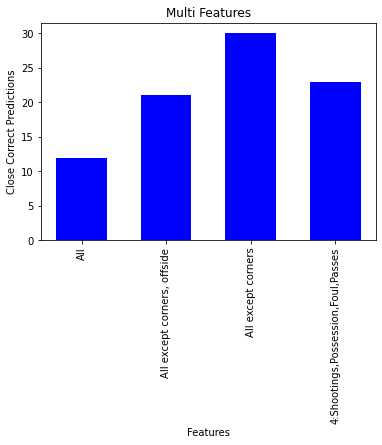

In [11]:
left_coordinates=[1,2,3,4]
heights=[12,21,30,23]
bar_labels=["All", "All except corners, offside", "All except corners", "4:Shootings,Possession,Foul,Passes"]
plt.bar(left_coordinates, heights,tick_label=bar_labels,width=0.6,color=["blue"])
plt.xticks(rotation='vertical')
plt.xlabel('Features')
plt.ylabel("Close Correct Predictions")
plt.title("Multi Features")
plt.savefig('Multi_Feature_close',bbox_inches='tight') 
plt.show()


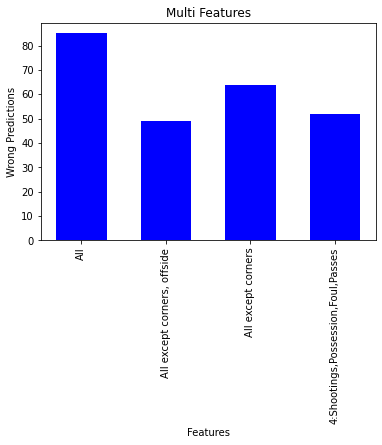

In [12]:
left_coordinates=[1,2,3,4]
heights=[85,49,64,52]
bar_labels=["All", "All except corners, offside", "All except corners", "4:Shootings,Possession,Foul,Passes"]
plt.bar(left_coordinates, heights,tick_label=bar_labels,width=0.6,color=["blue"])
plt.xticks(rotation='vertical')
plt.xlabel('Features')
plt.ylabel("Wrong Predictions")
plt.title("Multi Features")
plt.savefig('Multi_Feature_wrong',bbox_inches='tight') 
plt.show()
